## Import library

In [1]:
import datetime 
from datetime import timedelta 
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

from sklearn import svm

import matplotlib.font_manager as fm
import seaborn as sns
from itertools import product

## Data load

In [2]:
# df_israel_covid 이스라엘 데이터셋
# corona_isolation_per_day_ver_0059 일일 코로나 격리자 수 
# time_series_covid19_confirmed_global 누적 확진자 수 

base_path = './opendataset'
df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_large_2.csv')
# df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_small.csv')
df_israel_isolation_per_day = pd.read_csv(f'{base_path}/corona_isolation_per_day_ver_0069.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_confirmed_global = df_timeseries_confirm.sum().reset_index()

In [4]:
df_confirmed_global = df_confirmed_global.rename(columns={'index': 'global_confirmed_date', 0: 'global_confirmed_numsum'}).iloc[3:, :]

In [5]:
df_confirmed_global = df_confirmed_global.reset_index(drop=True)

In [6]:
df_confirmed_global

,global_confirmed_date,global_confirmed_numsum
0,1/22/20,557
1,1/23/20,655
2,1/24/20,941
3,1/25/20,1433
4,1/26/20,2118
...,...,...
589,9/2/21,219062869
590,9/3/21,219821446
591,9/4/21,220282354
592,9/5/21,220689611


In [7]:
df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_numsum'] - df_confirmed_global.shift(1)['global_confirmed_numsum']
df_confirmed_global = df_confirmed_global.dropna()
df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)

<ipython-input-7-dfada257fb77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)


In [8]:
def filter_date(date):
    year = f"20{date[-2:]}"
    month = date[:date.index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = date[date.index('/') + 1 : date.rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    res = f'{year}-{month}-{day}'
    return res

In [9]:
df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)

<ipython-input-9-62bcef823a49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)


## preprocessing

In [10]:
# 누적 확진자수를 2021-08-17 와 같은 포멧으로 전처리해주는 과정

rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [11]:
# 누적 확진자를 통해 일일 확진자 구하기

df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [12]:
# 일일 확진자수가 음수인 경우 그 전날 확진자를 가져다 쓰는 과정

for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34



In [13]:
df_numsum_confirmed.head(5)
# df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
5,2020-01-27,0,0


In [14]:
df_israel_covid = df_israel_covid[df_israel_covid['test_date'] < '2021-09-01']
df_israel_isolation_per_day = df_israel_isolation_per_day[df_israel_isolation_per_day['date'] < '2021-09-01']
df_numsum_confirmed = df_numsum_confirmed[df_numsum_confirmed['confirmed_date'] < '2021-06-01']
df_confirmed_global = df_confirmed_global[df_confirmed_global['global_confirmed_date'] < '2021-06-01']

In [15]:
df_israel_isolation_per_day['join_date'] = (pd.to_datetime(df_israel_isolation_per_day['date']) + timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 요일을 숫자로 기록한 컬럼 하나 만듬
df_israel_covid['weekday'] = pd.to_datetime(df_israel_covid['test_date']).dt.dayofweek

In [16]:
# 기존 이스라엘 데이터에 격리자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_israel_isolation_per_day, how='left', left_on='test_date', right_on='join_date')

In [17]:
df_israel_covid = df_israel_covid.sort_values('test_date')
df_israel_covid.head(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,weekday,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date
6925780,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925531,2020-03-11,1,0,1,0,0,שלילי,NaN,נקבה,Abroad,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925532,2020-03-11,1,0,0,1,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925533,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925534,2020-03-11,0,0,0,0,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11


In [18]:
# 기존 이스라엘 데이터에 이스라엘 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')

In [19]:
# 기존 이스라엘 데이터에 글로벌 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_confirmed_global, how='left', left_on='test_date', right_on='global_confirmed_date')

In [20]:
df_israel_covid.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num',
       'global_confirmed_date', 'global_confirmed_numsum',
       'global_confirmed_num'],
      dtype='object')

In [21]:
df_israel_covid.shape[0]

6925781

In [22]:
head_ne = df_israel_covid[df_israel_covid['head_ache'] == 0]
head_po = df_israel_covid[df_israel_covid['head_ache'] == 1]
print(head_ne.shape[0]+head_po.shape[0])

6925781


## 번역하기

In [23]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [24]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [25]:
def corona_result_map_vis(corona_result):
    if corona_result == -1: return 'Other'
    elif corona_result == 0: return 'Negative' 
    elif corona_result == 1: return 'Positive' 
    return ''

In [26]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [27]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [28]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

## model input preprocessing

In [29]:
df_israel_covid['indication_other'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 0 else 0)
df_israel_covid['indication_abroad'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 1 else 0)
df_israel_covid['indication_contact'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 2 else 0)

In [30]:
df_israel_covid[['test_indication', 'indication_other', 'indication_abroad', 'indication_contact']].head(30)

,test_indication,indication_other,indication_abroad,indication_contact
0,0,1,0,0
1,1,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
5,0,1,0,0
6,0,1,0,0
7,0,1,0,0
8,0,1,0,0
9,0,1,0,0


In [31]:
# other 빼버림
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]

In [32]:
df_israel_covid_without_o.shape[0]

6776916

In [33]:
# 성별 없는 사람들 빼버림
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]

In [34]:
df_israel_covid_without_o.shape[0]

6275088

In [35]:
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [36]:
df_israel_covid_without_o['test_date'].min()

'2020-03-11'

In [37]:
# # week_num 이라는 칼럼을 새로 만들었다. 1년에 52주라 
# def date_to_weeknum_map(test_date):
#     week_num_st_idx = 52
#     year_last_num = int(test_date[2:4])
#     week_num = datetime.date(int(test_date[:4]), int(test_date[5:7]), int(test_date[8:])).isocalendar()[1]
#     return week_num_st_idx * year_last_num + week_num

# Add 2nd degree data
추가 feature
- new_contact_with_confirmed
- positive_ratio
- weekday_ratio
- confirmed_ratio

In [38]:
df_israel_covid_without_o['new_contact_with_confirmed'] = df_israel_covid_without_o['new_contact_with_confirmed'].astype(int)

In [39]:
df_israel_covid_without_o['contact'] = df_israel_covid_without_o['new_contact_with_confirmed'] / 36903

In [40]:
df_confirm_by_sampling = df_israel_covid_without_o[df_israel_covid_without_o['corona_result'] == 1].groupby('test_date').count().reset_index()[['test_date', 'date']]
df_confirm_by_sampling = df_confirm_by_sampling.rename(columns={'test_date': 'yesterday', 'date': 'positive_cnt'})

In [41]:
df_israel_covid_without_o = pd.merge(df_israel_covid_without_o, df_confirm_by_sampling, how='left', left_on='date', right_on='yesterday')

In [42]:
df_israel_covid_without_o.shape[0]

6275088

In [43]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['positive_cnt'].isnull()]

In [44]:
df_israel_covid_without_o['positive_cnt'] = df_israel_covid_without_o['positive_cnt'].astype(int)

In [45]:
df_israel_covid_without_o['positive_ratio'] = df_israel_covid_without_o['positive_cnt'] / df_israel_covid_without_o['positive_cnt'].max()

In [46]:
df_israel_covid_without_o['weekday_ratio'] = df_israel_covid_without_o['weekday'] / 6

In [47]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / df_israel_covid_without_o['confirmed_num'].max()

In [48]:
df_israel_covid_without_o['global_confirmed_ratio'] = df_israel_covid_without_o['global_confirmed_num'] / df_israel_covid_without_o['global_confirmed_num'].max()

In [49]:
df_israel_covid_without_o['confirmed_num'].max()

11934.0

In [50]:
df_israel_covid_without_o.head(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,indication_other,indication_abroad,indication_contact,contact,yesterday,positive_cnt,positive_ratio,weekday_ratio,confirmed_ratio,global_confirmed_ratio
361,2020-03-12,1,1,1,1,0,0,-1,1,0,...,1,0,0,0.056174,2020-03-11,42,0.007795,0.5,0.00176,0.003864
362,2020-03-12,0,0,0,0,0,0,-1,0,0,...,1,0,0,0.056174,2020-03-11,42,0.007795,0.5,0.00176,0.003864
363,2020-03-12,0,0,0,0,0,0,-1,1,0,...,1,0,0,0.056174,2020-03-11,42,0.007795,0.5,0.00176,0.003864
364,2020-03-12,0,0,0,0,0,0,-1,1,0,...,1,0,0,0.056174,2020-03-11,42,0.007795,0.5,0.00176,0.003864
365,2020-03-12,0,0,0,0,0,0,-1,1,0,...,1,0,0,0.056174,2020-03-11,42,0.007795,0.5,0.00176,0.003864


In [51]:
df_israel_covid_without_o.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num',
       'global_confirmed_date', 'global_confirmed_numsum',
       'global_confirmed_num', 'indication_other', 'indication_abroad',
       'indication_contact', 'contact', 'yesterday', 'positive_cnt',
       'positive_ratio', 'weekday_ratio', 'confirmed_ratio',
       'global_confirmed_ratio'],
      dtype='object')

In [52]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['confirmed_ratio'].isnull()]

In [53]:
df_israel_covid_without_o['year'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[:4]))
df_israel_covid_without_o['month'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[5:7]))
df_israel_covid_without_o['day'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[8:10]))

In [54]:
# 여기서 내가 사용할 feature 고르기
df_input_only_symptom = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']]
df_input = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 'indication_other', 'indication_abroad', 'indication_contact', 'corona_result']]

raw_datas_only_symptom = df_input_only_symptom.values
raw_datas = df_input.values

In [55]:
df_israel_covid_without_o

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,contact,yesterday,positive_cnt,positive_ratio,weekday_ratio,confirmed_ratio,global_confirmed_ratio,year,month,day
361,2020-03-12,1,1,1,1,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
362,2020-03-12,0,0,0,0,0,0,-1,0,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
363,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
364,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
365,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375922,2021-04-22,0,0,0,0,0,0,-1,1,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375923,2021-04-22,0,0,0,0,0,0,-1,1,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375924,2021-04-22,0,0,0,0,0,0,-1,0,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375925,2021-04-22,0,0,0,0,0,0,-1,0,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22


In [56]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,confirmed_ratio,global_confirmed_ratio,indication_other,indication_abroad,indication_contact,corona_result
count,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06
mean,4.963493e-02,3.851017e-02,1.842978e-02,4.828174e-03,3.798640e-02,5.207305e-01,2.597199e-01,2.824709e-01,9.119273e-01,4.229586e-03,8.384312e-02,7.944592e-02
std,2.171896e-01,1.924244e-01,1.344995e-01,6.931713e-02,1.911634e-01,4.995701e-01,2.258918e-01,1.453237e-01,2.834006e-01,6.489759e-02,2.771524e-01,2.704335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.863713e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.315234e-02,1.754418e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.680912e-01,2.741507e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.026311e-01,3.930446e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [57]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)).astype(int)
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    print(len(data))
    print(test_indices.dtype)
    print(train_indices.dtype)
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
    test_data = data[test_indices]
    train_data = data[train_indices]
    
    return train_data, test_data

In [58]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [59]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

5345913
int64
int64
4276731
int64
int64


In [60]:
not_test_datas_only_symptom, test_datas_only_symptom = split_train_test(raw_datas_only_symptom, test_ratio=0.2)
train_datas_only_symptom, valid_datas_only_symptom = split_train_test(not_test_datas_only_symptom, test_ratio=0.2)

train_input_only_symptom, train_gt_only_symptom = split_input_gt(train_datas_only_symptom)
valid_input_only_symptom, valid_gt_only_symptom = split_input_gt(valid_datas_only_symptom)
test_input_only_symptom, test_gt_only_symptom = split_input_gt(train_datas_only_symptom)

5345913
int64
int64
4276731
int64
int64


In [61]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(3421385, 11) (3421385,) (855346, 11) (855346,) (1069182, 11) (1069182,)


In [62]:
print(train_input_only_symptom.shape, train_gt_only_symptom.shape, valid_input_only_symptom.shape, valid_gt_only_symptom.shape, test_input_only_symptom.shape, test_gt_only_symptom.shape)

(3421385, 5) (3421385,) (855346, 5) (855346,) (3421385, 5) (3421385,)


In [63]:
train_input.shape

(3421385, 11)

In [64]:
class IsraelDataset(Dataset):
    def __init__(self, input_data, gt, transform=None, target_transform=None):
        self.input_data = input_data
        self.gt = gt
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.gt[idx]

In [65]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [66]:
def display_performance(clf, pred, valid_input, valid_gt, save_name=None):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    
    plot_roc_curve(clf, valid_input, valid_gt)
    
    if save_name != None: plt.savefig(f'./eda_result/{save_name}.png')

In [67]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(train_input, train_gt)

accuracy 0.9190
precision 0.1853
recall 0.4750
f1-score 0.2666
[[773510  55336]
 [ 13913  12587]]


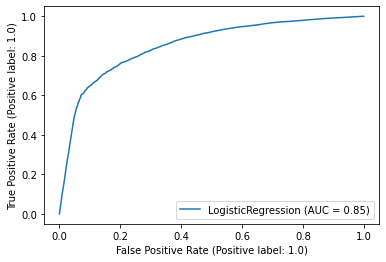

In [68]:
pred = logistic_clf.predict(valid_input)
display_performance(logistic_clf, pred, valid_input, valid_gt, 'logistic_auc')

In [69]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
#         nn.BatchNorm1d(9)
        self.fcs1 = nn.Sequential(
            nn.Linear(11, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
#         dropout 넣기
#         nn.linear, L1 norm L2 norm
        self.fcs2 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs3 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs4 = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.fcs5 = nn.Sequential(
            nn.Linear(400, 1),
#             nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 11)
        x = self.fcs1(x)
        x = x + self.fcs2(x)
        x = x + self.fcs3(x)
        x = x + self.fcs4(x)
        pred = self.fcs5(x)
        return pred

In [70]:
training_data = IsraelDataset(torch.Tensor(train_input), torch.Tensor(train_gt.reshape(-1, 1)))
valid_data = IsraelDataset(torch.Tensor(valid_input), torch.Tensor(valid_gt.reshape(-1, 1)))
test_data = IsraelDataset(torch.Tensor(test_input), torch.Tensor(test_gt.reshape(-1, 1)))
                          
train_dataloader = DataLoader(training_data, batch_size = 512, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

train_input.shape, valid_input.shape, test_input.shape

((3421385, 11), (855346, 11), (1069182, 11))

In [71]:
for val_inputs, val_labels in valid_dataloader:
    break
print(val_inputs.shape)

print(val_inputs.shape)

torch.Size([128, 11])
torch.Size([128, 11])


In [72]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional


def conv3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv1d:
    return nn.Conv1d(in_planes, out_planes,
                     kernel_size=3,
                     stride=stride, padding=1,
                     groups=groups, bias=False,
                     )


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, ) -> None:
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm1d
        self.conv1 = conv3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, n_channels=64, dropout=0.2):

        super(ResNet, self).__init__()

        self.inplanes = 1
        self.outplanes = n_channels
        self.conv1 = nn.Conv1d(self.inplanes, self.outplanes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.outplanes)
        self.relu = nn.ReLU(inplace=True)

        # Update inplanes for the next layer
        self.inplanes = self.outplanes

        # ResNet blocks
        self.layer1 = self._make_layer(block, n_channels, layers[0])
        self.layer2 = self._make_layer(block, n_channels, layers[1], stride=1,)
        self.layer3 = self._make_layer(block, n_channels, layers[2], stride=1,)
        self.layer4 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer5 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer6 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer7 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer8 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.avgpool = nn.AdaptiveAvgPool1d((1, ))
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.inplanes * block.expansion, num_classes)

    def _make_layer(self, block, planes: int, blocks: int, stride: int = 1, dilate: bool = False):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [73]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [74]:
model = BaselineModel().to(device)

In [75]:
model

BaselineModel(
  (fcs1): Sequential(
    (0): Linear(in_features=11, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs3): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs4): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs5): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
  )
)

In [76]:
model.load_state_dict(torch.load('./eda_result/cnn_model_epoch35_v4.pth'))

FileNotFoundError: [Errno 2] No such file or directory: './eda_result/cnn_model_epoch35_v4.pth'

In [ ]:
model.eval()

In [ ]:
# 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 
# 'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 
# 'indication_other', 'indication_abroad', 'indication_contact'
mock_input = torch.Tensor([[1, 0, 0, 0, 0, 0, 0.6, 0.8, 1, 0, 0]]).to(device)
mock_input = torch.unsqueeze(mock_input, 1)

torch.sigmoid(model(mock_input))

In [ ]:
# ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 
#  'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 
#  'test_indication', 'corona_result']

In [ ]:
symp_other_x = []
symp_other_y = []

symp_abroad_x = []
symp_abroad_y = []

symp_contact_x = []
symp_contact_y = []

for i in range(11935):
    symp_input_o = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 1, 0, 0]]).to(device), 1)
    symp_input_a = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 0, 1, 0]]).to(device), 1)
    symp_input_c = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 0, 0, 1]]).to(device), 1)
    
    if i % 10 == 0:
        symp_other_x.append(i/11934)
        symp_other_y.append(torch.sigmoid(model(symp_input_o)).item())
        
        symp_abroad_x.append(i/11934)
        symp_abroad_y.append(torch.sigmoid(model(symp_input_a)).item())
        
        symp_contact_x.append(i/11934)
        symp_contact_y.append(torch.sigmoid(model(symp_input_c)).item())

In [ ]:
plt.plot(symp_other_x, symp_other_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()

In [ ]:
plt.plot(symp_abroad_x, symp_abroad_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()

In [ ]:
plt.plot(symp_contact_x, symp_contact_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()